## SVM Implementation (reused from previous) on scaled non-reduced dataset

implem_new

Imports

In [18]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, randint, uniform

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

Set random seed for reproductibility

In [16]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('CleanedData/dataset_preprocessed.csv')

Take sample for (initial) tests

In [5]:
df_scaled_sample = df_scaled.sample(n=500, random_state=seed)
#df_scaled_sample = df_scaled

Train-Test Split

In [6]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [7]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [9]:
model = SVC(random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.64
F1 score: [0.         0.73134328 0.46875   ]


Metrics for SVM_unparametrized:
Accuracy: 0.6400
Weighted F1: 0.5959
Weighted Precision: 0.6941
Weighted Recall: 0.6400
Macro-Averaged Precision: 0.4770
Macro-Averaged Recall: 0.4228
F1: [0.         0.73134328 0.46875   ]
Precision: [0.         0.59756098 0.83333333]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         2
     Class 1       0.60      0.94      0.73        52
     Class 2       0.83      0.33      0.47        46

    accuracy                           0.64       100
   macro avg       0.48      0.42      0.40       100
weighted avg       0.69      0.64      0.60       100

Confusion Matrix


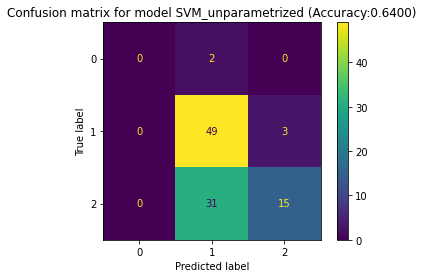

In [10]:
_ = calculate_metrics('SVM_unparametrized', y_test, predictions)

## Grid Search CV

In [11]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

model = SVC(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

printv = ""
printk = ""
for key in grid_search.best_params_:
    printk += f"{key}, "
    printv += f"{grid_search.best_params_[key]}, "
print("The parameters with the highest score:")
print(printk)
print(printv)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

print("Accuracy achieved for best parameters:", accuracy_score(y_test, predictions))
print("F1 score for best parameters:", f1_score(y_test, predictions, average=None))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
The parameters with the highest score:
C, gamma, kernel, 
100, scale, linear, 
Accuracy achieved for best parameters: 0.69
F1 score for best parameters: [0.         0.74576271 0.625     ]


Metrics for SVM_GS_CV_best:
Accuracy: 0.6900
Weighted F1: 0.6753
Weighted Precision: 0.6849
Weighted Recall: 0.6900
Macro-Averaged Precision: 0.4673
Macro-Averaged Recall: 0.4632
F1: [0.         0.74576271 0.625     ]
Precision: [0.         0.66666667 0.73529412]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         2
     Class 1       0.67      0.85      0.75        52
     Class 2       0.74      0.54      0.62        46

    accuracy                           0.69       100
   macro avg       0.47      0.46      0.46       100
weighted avg       0.68      0.69      0.68       100

Confusion Matrix


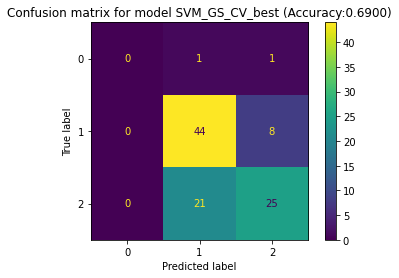

In [12]:
_= calculate_metrics('SVM_GS_CV_best', y_test, predictions)

In [13]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model => best parameters = no parameters :D
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                              params  mean_test_score
29   {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}         0.752441
25  {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}         0.752441
17   {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}         0.729997
21    {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}         0.729997
28      {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}         0.720046
16      {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}         0.707646
31  {'C': 100, 'gamma': 'auto', 'kernel': 'sigmoid'}         0.699996
24     {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}         0.687689
18     {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}         0.677571
20       {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}         0.675046


In [14]:
# Predicting using other alternatives of fine-tuning from top 10 performances

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = SVC(random_state=14, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)


Parameters from place:  0   {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}
Accuracy for chosen parameters: 0.69
Parameters from place:  1   {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy for chosen parameters: 0.69
Parameters from place:  2   {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy for chosen parameters: 0.68
Parameters from place:  3   {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
Accuracy for chosen parameters: 0.68
Parameters from place:  4   {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.68
Parameters from place:  5   {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.66
Parameters from place:  6   {'C': 100, 'gamma': 'auto', 'kernel': 'sigmoid'}
Accuracy for chosen parameters: 0.67
Parameters from place:  7   {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.65
Parameters from place:  8   {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy for chosen parameter

In [19]:
param_distributions = {
    'C': expon(scale=100),
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],  # for 'poly' kernel
    'gamma': expon(scale=.1),  # for 'rbf', 'poly' and 'sigmoid'
    'coef0': uniform(0, 10)  # significant for 'poly' and 'sigmoid'
}

random_search = RandomizedSearchCV(estimator=SVC(random_state=seed), param_distributions=param_distributions, n_iter=50, cv=4, verbose=2, random_state=14, n_jobs=-1, scoring='accuracy')
random_search.fit(X_train, y_train)

random_results = random_search.cv_results_
random_sorted_results = pd.DataFrame(random_results).sort_values(by='mean_test_score', ascending=False)

print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_

predictions = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average=None)

print("Accuracy for best parameters:", accuracy)
print("F1 score for best parameters:", f1)


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best parameters found:  {'C': 511.86203413314956, 'coef0': 3.0524216557593586, 'degree': 4, 'gamma': 0.09080225467042946, 'kernel': 'linear'}
Accuracy for best parameters: 0.67
F1 score for best parameters: [0.         0.72413793 0.6097561 ]


Metrics for SVM_RS_CV_best:
Accuracy: 0.6700
Weighted F1: 0.6570
Weighted Precision: 0.6607
Weighted Recall: 0.6700
Macro-Averaged Precision: 0.4502
Macro-Averaged Recall: 0.4504
F1: [0.         0.72413793 0.6097561 ]
Precision: [0.         0.65625    0.69444444]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         2
     Class 1       0.66      0.81      0.72        52
     Class 2       0.69      0.54      0.61        46

    accuracy                           0.67       100
   macro avg       0.45      0.45      0.44       100
weighted avg       0.66      0.67      0.66       100

Confusion Matrix


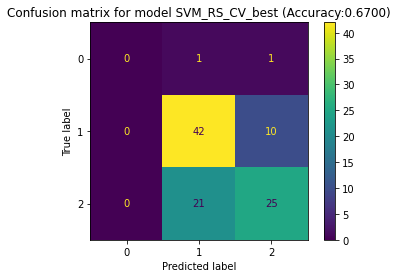

In [21]:
_= calculate_metrics('SVM_RS_CV_best', y_test, predictions)

In [22]:
random_sorted_results = random_sorted_results[['params', 'mean_test_score']]
random_sorted_results['accuracy'] = 0
print(random_sorted_results.head(10))

                                               params  mean_test_score  \
42  {'C': 511.86203413314956, 'coef0': 3.052421655...           0.7525   
3   {'C': 339.10610651443085, 'coef0': 1.514222821...           0.7500   
37  {'C': 226.43895178636396, 'coef0': 4.409070367...           0.7475   
27  {'C': 105.1644420392561, 'coef0': 2.6761772236...           0.7475   
21  {'C': 273.3475219461634, 'coef0': 9.9505030295...           0.7475   
30  {'C': 140.76590012944774, 'coef0': 1.330840513...           0.7450   
40  {'C': 148.12266365239677, 'coef0': 5.251120281...           0.7450   
13  {'C': 24.985690984260426, 'coef0': 4.997879415...           0.7400   
35  {'C': 68.34897793931825, 'coef0': 4.7407198550...           0.7375   
48  {'C': 60.47945474706257, 'coef0': 4.3994255872...           0.7375   

    accuracy  
42         0  
3          0  
37         0  
27         0  
21         0  
30         0  
40         0  
13         0  
35         0  
48         0  


In [23]:
for i in range(10):

  params = random_sorted_results.iloc[i]['params']

  model = SVC(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  chosen_accuracy = accuracy_score(y_test, predictions)
  random_sorted_results.iloc[i, 2] = chosen_accuracy

In [24]:
print("The parameters with the highest score: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_train)

print("Accuracy achieved for best parameters on training data:", accuracy_score(y_train, predictions))

The parameters with the highest score:  {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy achieved for best parameters on training data: 0.8375
